## Импорты

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.3 MB/s eta 0:00:00


In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from joblib import Parallel, delayed
from sklearn.metrics import roc_curve
import itertools

import joblib

Загрузим данные.

In [3]:
train_Mortgage = pd.read_csv('train_Mortgage.csv')
val_Mortgage = pd.read_csv('val_Mortgage.csv')

train_Pension = pd.read_csv('train_Pension.csv')
val_Pension = pd.read_csv('val_Pension.csv')

train_Savings = pd.read_csv('train_Savings.csv')
val_Savings = pd.read_csv('val_Savings.csv')

In [4]:
test = pd.read_csv('unknown_behaviors.csv')
test.head()

customer_id  age  age_youngest_child  debt_equity  gender  bad_payment  \
0        44256   38                  11           38       1            0   
1        46883   30                   1           30       0            0   
2        32387   41                  13           41       1            0   
3        25504   42                  14           42       1            0   
4        35979   42                  14           42       1            0   

   gold_card  pension_plan  household_debt_to_equity_ratio   income  \
0          0             0                              58  47958.0   
1          0             0                              55  48606.0   
2          0             0                              59  42152.0   
3          0             0                              57  39788.0   
4          0             0                              53  44365.0   

   members_in_household  months_current_account  months_customer  \
0                     4                      41               48   
1                     2                      23               36   
2                     4                      39               48   
3                     3                      21               24   
4                     6                      41               48   

   call_center_contacts  loan_accounts  number_products  number_transactions  \
0                     2              1                2                    1   
1                     2              4                3                    2   
2                     1              0                1                    1   
3                     2              3                0                    0   
4                     3              2                3                    1   

   non_worker_percentage  white_collar_percentage  rfm_score  
0                      9                       31      7.949  
1                     11                       33     11.437  
2                     11                       29      7.462  
3                     15                       27      0.000  
4                      5                       41      7.806

Выделим нужные нам для обучения и валидации выборки.

In [5]:
test = test.drop(['customer_id'], axis=1)
feature_columns = test.columns

X_train_Mortgage = train_Mortgage[feature_columns]
y_train_Mortgage = train_Mortgage[['Mortgage']]

X_val_Mortgage = val_Mortgage[feature_columns]
y_val_Mortgage = val_Mortgage[['Mortgage']]

X_train_Pension = train_Pension[feature_columns]
y_train_Pension = train_Pension[['Pension']]

X_val_Pension = val_Pension[feature_columns]
y_val_Pension = val_Pension[['Pension']]

X_train_Savings = train_Savings[feature_columns]
y_train_Savings = train_Savings[['Savings']]

X_val_Savings = val_Savings[feature_columns]
y_val_Savings = val_Savings[['Savings']]

In [ ]:
# class Stacking:
#     def __init__(self, estimators, final_estimator, blending=False, cv=5, n_jobs=-1):
#         self.estimators = estimators
#         self.final_estimator = final_estimator
#         self.blending = blending
#         self.cv = cv
#         self.n_jobs = n_jobs

#     def _X_pred(self, estimator, data):
#         if self.blending:
#             X_train_v, y_train_v, X_val = data
#             return estimator.fit(X_train_v, y_train_v).predict(X_val)
#         else:
#             X_train, y_train = data
#             return cross_val_predict(estimator, X_train, y_train, cv=self.cv)

#     def _X_test_pred(self, estimator, data):
#         X_train, y_train, X_test = data

#         return estimator.fit(X_train, y_train).predict(X_test)

#     def _meta_data(self, X_train, y_train, X_test):
#         if self.blending:
#             #used hold-out cross-validation
#             X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, random_state=0)
#             train_data = [X_train_v, y_train_v, X_val]
#             test_data = [X_train_v, y_train_v, X_test]
#             meta_y_train = y_val
#         else:
#             train_data = [X_train, y_train]
#             test_data = [X_train, y_train, X_test]
#             meta_y_train = y_train

#         cv_X_train_preds = (delayed(self._X_pred)(est, train_data) for est in self.estimators)
#         X_test_preds = (delayed(self._X_test_pred)(est, test_data) for est in self.estimators)

#         meta_X_train = pd.DataFrame(Parallel(n_jobs=self.n_jobs)(cv_X_train_preds))
#         meta_X_test = pd.DataFrame(Parallel(n_jobs=self.n_jobs)(X_test_preds))

#         return meta_X_train.T, meta_y_train, meta_X_test.T

#     def fit_predict(self, X_train, y_train, X_test):
#         # meta learner or blender
#         meta_X_train, meta_y_train, meta_X_test = self._meta_data(X_train, y_train, X_test)

#         return self.final_estimator.fit(meta_X_train, meta_y_train).predict(meta_X_test)

In [ ]:
# estimators = [LogisticRegression(C=0.001, max_iter=500, solver='lbfgs'),
#               xgb.XGBClassifier(n_estimators=272, max_depth=14, learning_rate=0.12753267344109367,
#                                            subsample=0.6941543019427293, colsample_bytree=0.9619344906331702,
#                                            min_child_weight=10, gamma=4.898623396935431, reg_alpha=9.406013115778222,
#                                            reg_lambda=3.72978306308289, scale_pos_weight=1.4227931697036977),
#               ExtraTreesClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=100)]

# estimator = MLPClassifier(random_state=42, max_iter=300)
# stacking_clf = Stacking(estimators=estimators, final_estimator=estimator)
# stacking_pred_res = stacking_clf.fit_predict(X_train_Pension, y_train_Pension, X_val_Pension)
# stacking_roc_auc = roc_auc_score(y_val_Pension, stacking_pred_res)
# print(f'stacking_roc_auc: {stacking_roc_auc}')
# print(stacking_pred_res, '', sep='\n')

# blending_clf = Stacking(estimators=estimators, final_estimator=estimator, blending=True)
# blending_pred_res = blending_clf.fit_predict(X_train_Pension, y_train_Pension, X_val_Pension)
# blending_roc_auc = roc_auc_score(y_val_Pension, blending_pred_res)
# print(f'blending_roc_auc: {blending_roc_auc}')
# print(blending_pred_res)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


stacking_roc_auc: 0.5254582484725051
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


blending_roc_auc: 0.5621181262729124
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [6]:
def roc_auc(models, names, colors, X_test, y_test, title):

    plt.figure(figsize=(8, 6))
    for i in range(len(models)):
        y_pred_proba = models[i].predict_proba(X_test[i])[:, 1] # Вероятности для класса 1
        fpr, tpr, thresholds = roc_curve(y_test[i], y_pred_proba)
        roc_auc = roc_auc_score(y_test[i], y_pred_proba)
        print(f"AUC for {names[i]}: {roc_auc}")

        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{names[i]} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(prop={'size': 12})
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(title)
plt.show()

## Стекинг

### Параметры лучших моделей

#### Mortgage

CatBoost

In [7]:
cb_mortgage = CatBoostClassifier(iterations=839, learning_rate=0.05774795442279825, depth=6,
                                 l2_leaf_reg=0.2880865175456189, random_strength=0.16254277485904814,
                                 bagging_temperature=0.7992786757360438, border_count=32, boosting_type='Ordered')

XGBoost

In [8]:
xgb_mortgage = xgb.XGBClassifier(n_estimators=234, max_depth=14, learning_rate=0.13020051661181956,
                                 subsample=0.5000183482043092, colsample_bytree=0.9712108470499956,
                                 min_child_weight=10, gamma=4.927111346239827, reg_alpha=2.3159564553387995,
                                 reg_lambda=1.7788240357504277, scale_pos_weight=1.155068929743032)

LightGBM

In [9]:
lgb_mortgage = lgb.LGBMClassifier(n_estimators=891, learning_rate=0.2775178145806826, num_leaves=154, max_depth=4,
                                  min_child_samples=5, subsample=0.875834146327149, colsample_bytree=0.9367342318343456,
                                  reg_alpha=4.0997572412343555, reg_lambda=1.3718029339702882)

ExtraTrees

In [10]:
et_mortgage = ExtraTreesClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=200)

LogisticRegression

In [11]:
lr_mortgage = LogisticRegression(C=0.01, max_iter=500, solver='lbfgs')

MLP

In [12]:
mlp_mortgage = MLPClassifier(max_iter=300)

#### Pension

CatBoost

In [13]:
cb_pension = CatBoostClassifier(iterations=200, learning_rate=0.010875325239675968, l2_leaf_reg=0.010817134192675052,
                                random_strength=4.740509717654505, bagging_temperature=0.9584104224319896,
                                border_count=75, colsample_bylevel=0.25113614025415143, depth=1, boosting_type='Plain')

XGBoost

In [14]:
xgb_pension = xgb.XGBClassifier(n_estimators=238, max_depth=3, learning_rate=0.058427369161116946,
                                subsample=0.9293867219852593, colsample_bytree=0.5238187849054002,
                                min_child_weight=6, gamma=4.7308173402905505, reg_alpha=8.066467399907712,
                                reg_lambda=4.390801165747763, scale_pos_weight=1.0066125076750385)

LightGBM

In [15]:
lgb_pension = lgb.LGBMClassifier(n_estimators=1191, learning_rate=0.11153678049934727, num_leaves=107, max_depth=3,
                                 min_child_samples=41, subsample=0.5173705475484477, colsample_bytree=0.7026966245620551,
                                 reg_alpha=0.45638892145814025, reg_lambda=5.315359029396548)

ExtraTrees

In [16]:
et_pension = ExtraTreesClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=100)

LogisticRegression

In [17]:
lr_pension = LogisticRegression(C=0.001, max_iter=500, solver='lbfgs')

MLP

In [18]:
mlp_pension = MLPClassifier(max_iter=300)

#### Savings

CatBoost

In [19]:
cb_savings = CatBoostClassifier(iterations=205, learning_rate=0.041965496183629054, l2_leaf_reg=0.0033091053333706402,
                                random_strength=0.4267643014670958, bagging_temperature=0.6548287821971729, border_count=254,
                                colsample_bylevel=0.6355211623405239, depth=5, boosting_type='Plain')

XGBoost

In [20]:
xgb_savings = xgb.XGBClassifier(n_estimators=1446, max_depth=3, learning_rate=0.17633766607373635,
                                subsample=0.8802608079409611, colsample_bytree=0.6399123535237496,
                                min_child_weight=10, gamma=4.7135127571247475, reg_alpha=7.307229547015628,
                                reg_lambda=0.5506026977366328, scale_pos_weight=4.0245802517341716)

LightGBM

In [21]:
lgb_savings = lgb.LGBMClassifier(n_estimators=903, learning_rate=0.2620735099496511, num_leaves=198, max_depth=5,
                                 min_child_samples=98, subsample=0.5818744149073714, colsample_bytree=0.9979504029037664,
                                 reg_alpha=3.2759181752443514, reg_lambda=9.427794042824686)

ExtraTrees

In [22]:
et_savings = ExtraTreesClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200)

LogisticRegression

In [23]:
lr_savings = LogisticRegression(C=0.1, max_iter=500, solver='lbfgs')

MLP

In [24]:
mlp_savings = MLPClassifier(max_iter=300)

Попробуем стекинг с моделями `XGBoost`, `ExtraTrees` и мета-моделью `MLP`.

In [25]:
def run_stacking(sk_estimators, estimator, X_train, y_train, X_val, y_val):

    sk_stacking_clf = StackingClassifier(estimators=sk_estimators, final_estimator=estimator)

    sk_stacking_clf.stack_method = 'predict_proba'
    sk_stacking_clf.fit(X_train, y_train)
    sk_stacking_pred_res = sk_stacking_clf.predict_proba(X_val)[:, 1]
    sk_stacking_roc_auc = roc_auc_score(y_val, sk_stacking_pred_res)
    return sk_stacking_clf, sk_stacking_roc_auc

In [33]:
# def generate_combinations(estimators):
#     """
#     Генерирует все возможные комбинации объектов из списка без повторений и без учета порядка.
#     estimators: Список объектов (например, estimators_pension_cb_xgb_lgb).
#     Returns: Список кортежей, представляющих все возможные комбинации объектов.
#     """

#     combinations = []
#     for r in range(1, len(estimators) + 1):
#         for combination in itertools.combinations(estimators, r):
#             combinations.append(combination)
#     return combinations

In [37]:
# pension_estimators =  [('cb', cb_pension),
#                        ('xgb', xgb_pension),
#                        ('lgb', lgb_pension),
#                        ('et', et_pension),
#                        ('lr', lr_pension),
#                        ('mlp', mlp_pension)]

# all_pension_combinations = generate_combinations(pension_estimators)

In [ ]:
# pension_estimators =  [('cb', cb_pension),
#                        ('xgb', xgb_pension),
#                        ('lgb', lgb_pension),
#                        ('et', et_pension),
#                        ('lr', lr_pension),
#                        ('mlp', mlp_pension)]

# all_pension_combinations = generate_combinations(pension_estimators)


# for combination in all_combinations:
#     combination[0][0]
#     sk_stacking_clf_cb_xgb_lgb, roc_auc_cb_xgb_lgb = run_stacking(estimators_cb_xgb_lgb, LogisticRegression(), X_train_Mortgage, y_train_Mortgage, X_val_Mortgage, y_val_Mortgage)
#     my_function(list(combination))  #Преобразуем кортеж в список

### CatBoost, XGBoost, LightGBM

#### Mortgage

##### Meta LR

In [27]:
estimators_mortgage_cb_xgb_lgb = [('cb', cb_mortgage),
                                  ('xgb', xgb_mortgage),
                                  ('lgb', lgb_mortgage)]


sk_stacking_mortgage_clf_cb_xgb_lgb, roc_auc_mortgage_cb_xgb_lgb = run_stacking(
    estimators_mortgage_cb_xgb_lgb, LogisticRegression(), X_train_Mortgage, y_train_Mortgage, X_val_Mortgage, y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

AUC for Stacking CB, XGB, LGB with meta LR for Mortgage: 0.9418472526580635


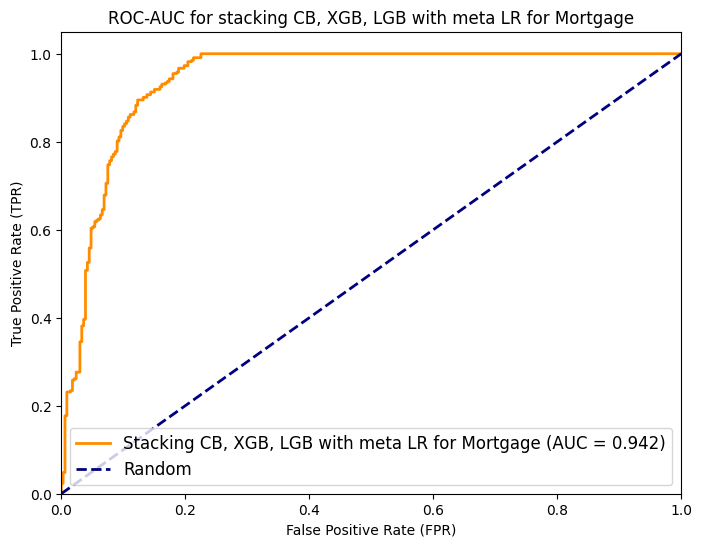

In [28]:
rf_models = [sk_stacking_mortgage_clf_cb_xgb_lgb]
rf_names = ["Stacking CB, XGB, LGB with meta LR for Mortgage"]
colors = ["darkorange"]
X_test = [X_val_Mortgage]
y_test = [y_val_Mortgage]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking CB, XGB, LGB with meta LR for Mortgage")

##### Meta MLP

In [29]:
estimators_mortgage_cb_xgb_lgb_metamlp = [('cb', cb_mortgage),
                                          ('xgb', xgb_mortgage),
                                          ('lgb', lgb_mortgage)]


sk_stacking_mortgage_clf_cb_xgb_lgb_metamlp, roc_auc_mortgage_cb_xgb_lgb_metamlp = run_stacking(
    estimators_mortgage_cb_xgb_lgb_metamlp, MLPClassifier(max_iter=300), X_train_Mortgage, y_train_Mortgage, X_val_Mortgage, y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

AUC for Stacking CB, XGB, LGB with meta MLP for Mortgage: 0.9416037659280903


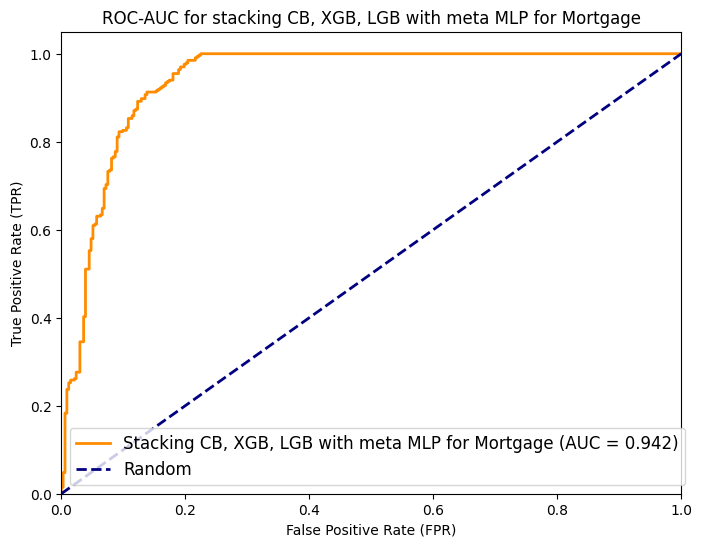

In [30]:
rf_models = [sk_stacking_mortgage_clf_cb_xgb_lgb_metamlp]
rf_names = ["Stacking CB, XGB, LGB with meta MLP for Mortgage"]
colors = ["darkorange"]
X_test = [X_val_Mortgage]
y_test = [y_val_Mortgage]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking CB, XGB, LGB with meta MLP for Mortgage")

#### Pension

##### Meta LR

In [31]:
estimators_pension_cb_xgb_lgb = [('cb', cb_pension),
                                ('xgb', xgb_pension),
                                ('lgb', lgb_pension)]


sk_stacking_pension_clf_cb_xgb_lgb, roc_auc_pension_cb_xgb_lgb = run_stacking(
    estimators_pension_cb_xgb_lgb, LogisticRegression(), X_train_Pension, y_train_Pension, X_val_Pension, y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

AUC for Stacking CB, XGB, LGB with meta LR for Pension: 0.7784852394008653


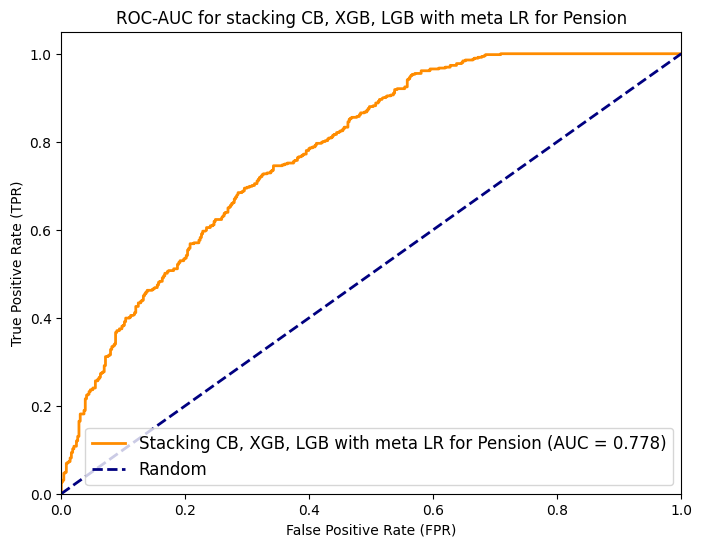

In [32]:
rf_models = [sk_stacking_pension_clf_cb_xgb_lgb]
rf_names = ["Stacking CB, XGB, LGB with meta LR for Pension"]
colors = ["darkorange"]
X_test = [X_val_Pension]
y_test = [y_val_Pension]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking CB, XGB, LGB with meta LR for Pension")

##### Meta MLP

In [33]:
estimators_pension_cb_xgb_lgb_metamlp = [('cb', cb_pension),
                                         ('xgb', xgb_pension),
                                         ('lgb', lgb_pension)]


sk_stacking_pension_clf_cb_xgb_lgb_metamlp, roc_auc_pension_cb_xgb_lgb_metamlp = run_stacking(
    estimators_pension_cb_xgb_lgb_metamlp, MLPClassifier(max_iter=300), X_train_Pension, y_train_Pension, X_val_Pension, y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

AUC for Stacking CB, XGB, LGB with meta MLP for Pension: 0.7771371447770667


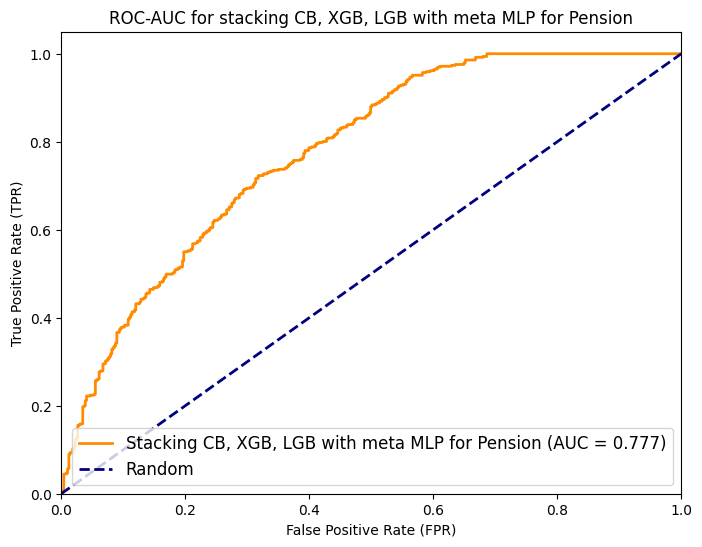

In [34]:
rf_models = [sk_stacking_pension_clf_cb_xgb_lgb_metamlp]
rf_names = ["Stacking CB, XGB, LGB with meta MLP for Pension"]
colors = ["darkorange"]
X_test = [X_val_Pension]
y_test = [y_val_Pension]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking CB, XGB, LGB with meta MLP for Pension")

#### Savings

##### Meta LR

In [35]:
estimators_savings_cb_xgb_lgb = [('cb', cb_savings),
                                ('xgb', xgb_savings),
                                ('lgb', lgb_savings)]


sk_stacking_savings_clf_cb_xgb_lgb, roc_auc_savings_cb_xgb_lgb = run_stacking(
    estimators_savings_cb_xgb_lgb, LogisticRegression(), X_train_Savings, y_train_Savings, X_val_Savings, y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further split

AUC for Stacking CB, XGB, LGB with meta LR for Savings: 0.6906095724939604


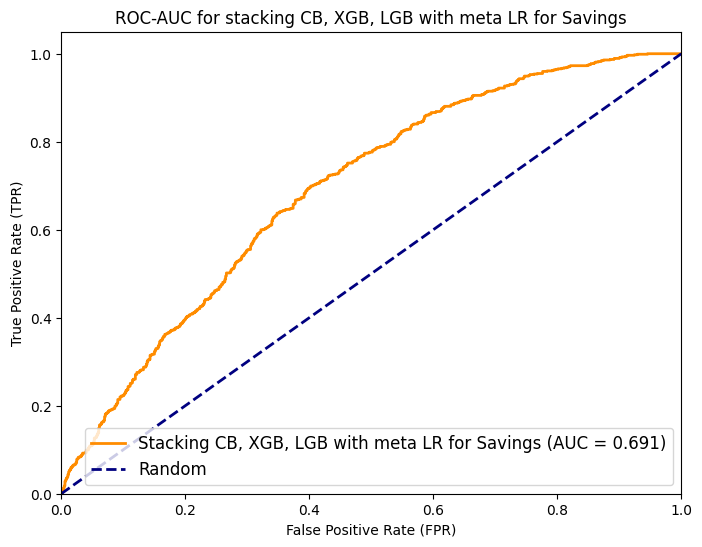

In [36]:
rf_models = [sk_stacking_savings_clf_cb_xgb_lgb]
rf_names = ["Stacking CB, XGB, LGB with meta LR for Savings"]
colors = ["darkorange"]
X_test = [X_val_Savings]
y_test = [y_val_Savings]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking CB, XGB, LGB with meta LR for Savings")

##### Meta MLP

In [37]:
estimators_savings_cb_xgb_lgb_metamlp = [('cb', cb_savings),
                                         ('xgb', xgb_savings),
                                         ('lgb', lgb_savings)]


sk_stacking_savings_clf_cb_xgb_lgb_metamlp, roc_auc_savings_cb_xgb_lgb_metamlp = run_stacking(
    estimators_savings_cb_xgb_lgb_metamlp, MLPClassifier(max_iter=300), X_train_Savings, y_train_Savings, X_val_Savings, y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training

AUC for Stacking CB, XGB, LGB with meta MLP for Savings: 0.6914876930079479


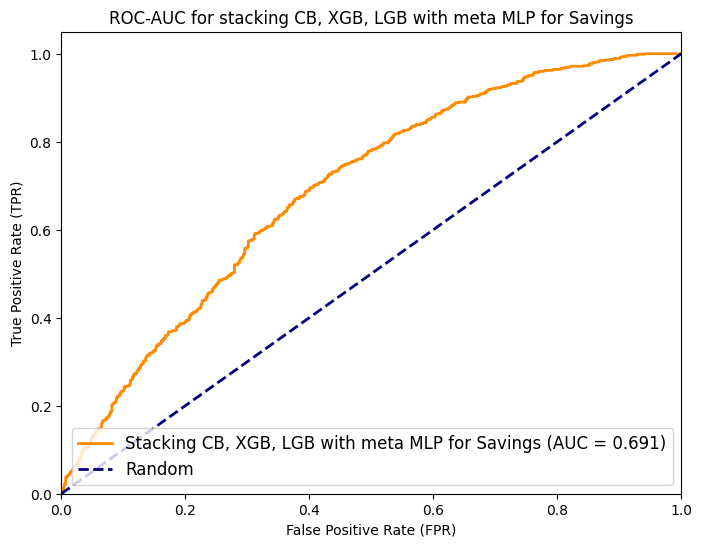

In [38]:
rf_models = [sk_stacking_savings_clf_cb_xgb_lgb_metamlp]
rf_names = ["Stacking CB, XGB, LGB with meta MLP for Savings"]
colors = ["darkorange"]
X_test = [X_val_Savings]
y_test = [y_val_Savings]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking CB, XGB, LGB with meta MLP for Savings")

### ExtraTrees, LogisticRegression, MLP

#### Mortgage

##### Meta LR

In [51]:
estimators_mortgage_et_lr_mlp = [('et', et_mortgage),
                                 ('lr', lr_mortgage),
                                 ('mlp', mlp_mortgage)]


sk_stacking_mortgage_clf_et_lr_mlp, roc_auc_mortgage_et_lr_mlp = run_stacking(
    estimators_mortgage_et_lr_mlp, LogisticRegression(), X_train_Mortgage, y_train_Mortgage, X_val_Mortgage, y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

AUC for Stacking ET, LR, MLP with meta LR for Mortgage: 0.9400887373860346


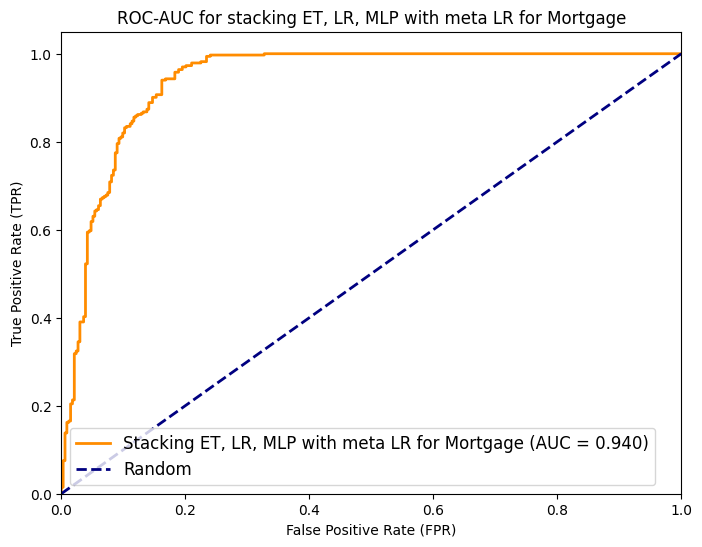

In [52]:
rf_models = [sk_stacking_mortgage_clf_et_lr_mlp]
rf_names = ["Stacking ET, LR, MLP with meta LR for Mortgage"]
colors = ["darkorange"]
X_test = [X_val_Mortgage]
y_test = [y_val_Mortgage]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, LR, MLP with meta LR for Mortgage")

##### Meta MLP

In [55]:
estimators_mortgage_et_lr_mlp_metamlp = [('et', et_mortgage),
                                         ('lr', lr_mortgage),
                                         ('mlp', mlp_mortgage)]


sk_stacking_mortgage_clf_et_lr_mlp_metamlp, roc_auc_mortgage_et_lr_mlp_metamlp = run_stacking(
    estimators_mortgage_et_lr_mlp_metamlp, MLPClassifier(max_iter=300), X_train_Mortgage, y_train_Mortgage, X_val_Mortgage, y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

AUC for Stacking ET, LR, MLP with meta MLP for Mortgage: 0.9404224043863683


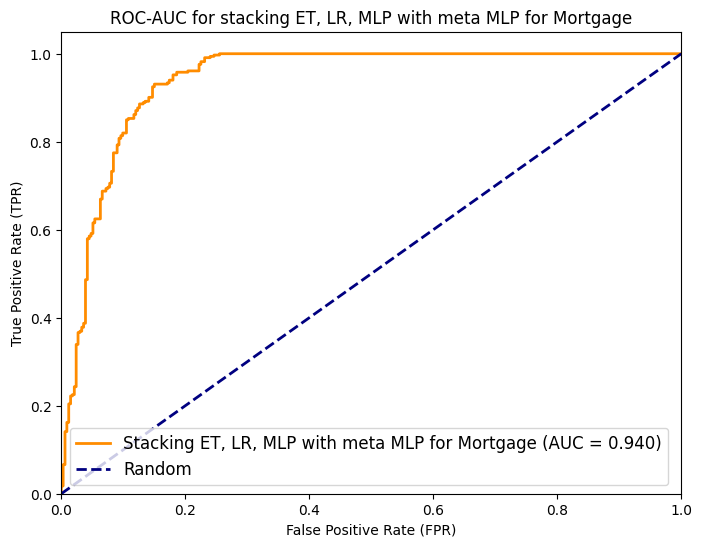

In [56]:
rf_models = [sk_stacking_mortgage_clf_et_lr_mlp_metamlp]
rf_names = ["Stacking ET, LR, MLP with meta MLP for Mortgage"]
colors = ["darkorange"]
X_test = [X_val_Mortgage]
y_test = [y_val_Mortgage]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, LR, MLP with meta MLP for Mortgage")

#### Pension

##### Meta LR

In [45]:
estimators_pension_et_lr_mlp = [('et', et_pension),
                                ('lr', lr_pension),
                                ('mlp', mlp_pension)]


sk_stacking_pension_clf_et_lr_mlp, roc_auc_pension_et_lr_mlp = run_stacking(
    estimators_pension_et_lr_mlp, LogisticRegression(), X_train_Pension, y_train_Pension, X_val_Pension, y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

AUC for Stacking ET, LR, MLP with meta LR for Pension: 0.7791572127210357


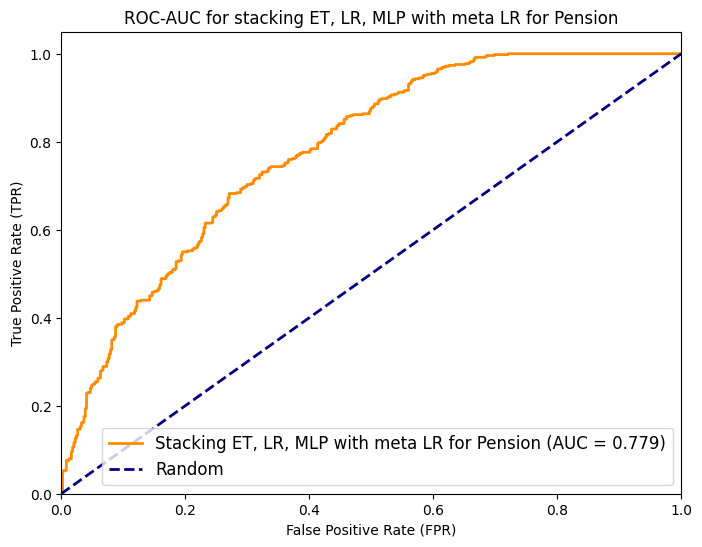

In [46]:
rf_models = [sk_stacking_pension_clf_et_lr_mlp]
rf_names = ["Stacking ET, LR, MLP with meta LR for Pension"]
colors = ["darkorange"]
X_test = [X_val_Pension]
y_test = [y_val_Pension]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, LR, MLP with meta LR for Pension")

##### Meta MLP

In [49]:
estimators_pension_et_lr_mlp_metamlp = [('et', et_pension),
                                        ('lr', lr_pension),
                                        ('mlp', mlp_pension)]


sk_stacking_pension_clf_et_lr_mlp_metamlp, roc_auc_pension_et_lr_mlp_metamlp = run_stacking(
    estimators_pension_et_lr_mlp_metamlp, MLPClassifier(max_iter=300), X_train_Pension, y_train_Pension, X_val_Pension, y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

AUC for Stacking ET, LR, MLP with meta MLP for Pension: 0.7763034001020404


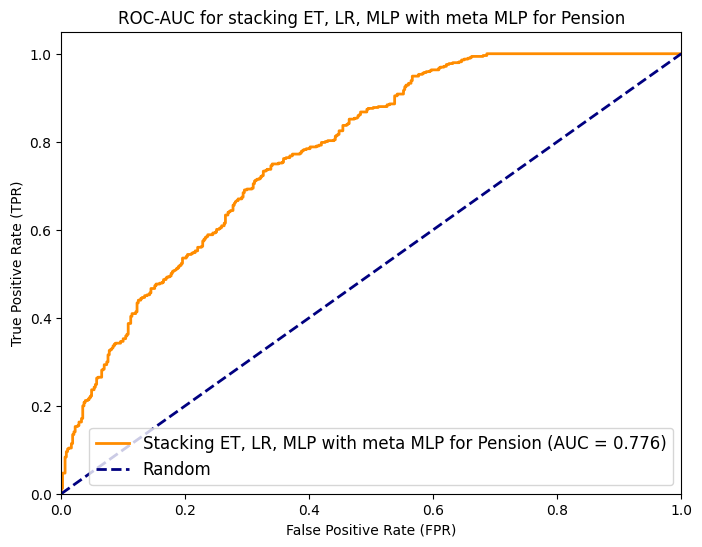

In [50]:
rf_models = [sk_stacking_pension_clf_et_lr_mlp_metamlp]
rf_names = ["Stacking ET, LR, MLP with meta MLP for Pension"]
colors = ["darkorange"]
X_test = [X_val_Pension]
y_test = [y_val_Pension]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, LR, MLP with meta MLP for Pension")

#### Savings

##### Meta LR

In [41]:
estimators_savings_et_lr_mlp = [('et', et_savings),
                                ('lr', lr_savings),
                                ('mlp', mlp_savings)]


sk_stacking_savings_clf_et_lr_mlp, roc_auc_savings_et_lr_mlp = run_stacking(
    estimators_savings_et_lr_mlp, LogisticRegression(), X_train_Savings, y_train_Savings, X_val_Savings, y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

AUC for Stacking ET, LR, MLP with meta LR for Savings: 0.6939609957634537


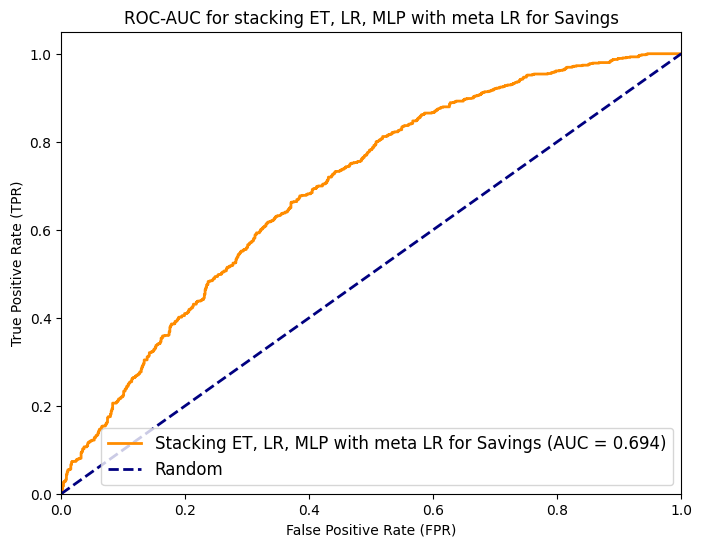

In [42]:
rf_models = [sk_stacking_savings_clf_et_lr_mlp]
rf_names = ["Stacking ET, LR, MLP with meta LR for Savings"]
colors = ["darkorange"]
X_test = [X_val_Savings]
y_test = [y_val_Savings]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, LR, MLP with meta LR for Savings")

##### Meta MLP

In [39]:
estimators_savings_et_lr_mlp_metamlp = [('et', et_savings),
                                        ('lr', lr_savings),
                                        ('mlp', mlp_savings)]


sk_stacking_savings_clf_et_lr_mlp_metamlp, roc_auc_savings_et_lr_mlp_metamlp = run_stacking(
    estimators_savings_et_lr_mlp_metamlp, MLPClassifier(max_iter=300), X_train_Savings, y_train_Savings, X_val_Savings, y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

AUC for Stacking ET, LR, MLP with meta MLP for Savings: 0.6957172367914288


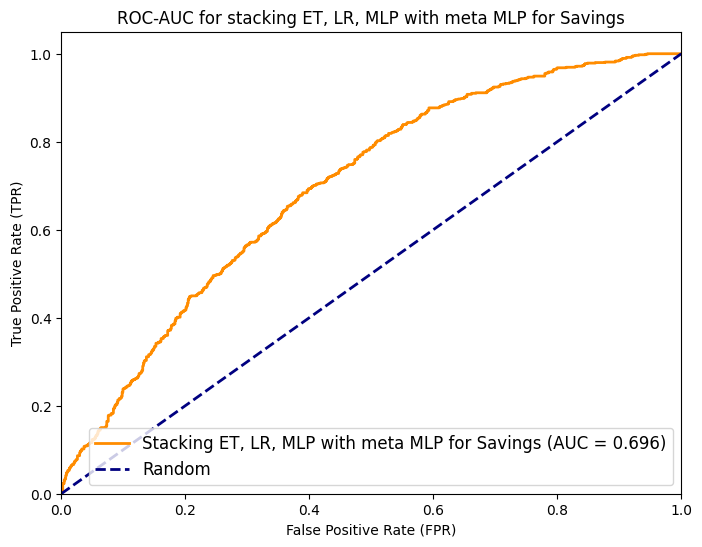

In [40]:
rf_models = [sk_stacking_savings_clf_et_lr_mlp_metamlp]
rf_names = ["Stacking ET, LR, MLP with meta MLP for Savings"]
colors = ["darkorange"]
X_test = [X_val_Savings]
y_test = [y_val_Savings]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, LR, MLP with meta MLP for Savings")

In [ ]:
# sk_estimators = [('et', ExtraTreesClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=100)),

#                  ('xgb', xgb.XGBClassifier(n_estimators=463, max_depth=10, learning_rate=0.02256416661808555, subsample=0.6240500941210322,
#                                            colsample_bytree=0.5546584061783684, min_child_weight=5, gamma=4.902355170236016,
#                                            reg_alpha=7.429380620689328, reg_lambda=9.476357985997664, scale_pos_weight=1.1944634247934323))]

# estimator = LogisticRegression()
# sk_stacking_clf = StackingClassifier(estimators=sk_estimators, final_estimator=estimator)

# feature_indexes = [1, 3]
# plt.figure(figsize=(12, 5))

# sk_stacking_clf.stack_method = 'predict_proba'
# sk_stacking_clf.fit(X_train_Pension, y_train_Pension)
# sk_stacking_pred_res = sk_stacking_clf.predict_proba(X_val_Pension)[:, 1]
# sk_stacking_roc_auc= roc_auc_score(y_val_Pension, sk_stacking_pred_res)
# print(f'sk_stacking_roc_auc with a predict_prob method: {sk_stacking_roc_auc}')

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


sk_stacking_roc_auc with a predict_prob method: 0.7785681990700222


<Figure size 1200x500 with 0 Axes>

AUC for Stacking Pension: 0.7785681990700222


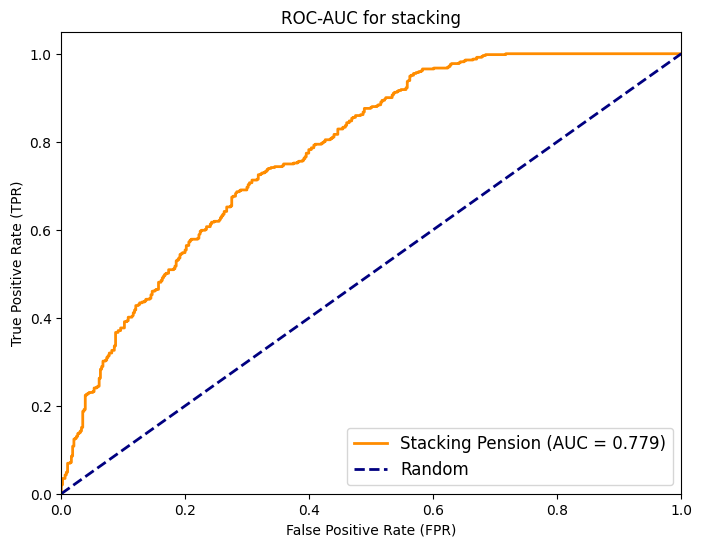

In [ ]:
# rf_models = [sk_stacking_clf]
# rf_names = ["Stacking Pension"]
# colors = ["darkorange"]
# X_test = [X_val_Pension]
# y_test = [y_val_Pension]
# roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking")

## Кастомный стекинг

Вспомним наилучшие модели для каждого таргета и попробуем их смиксовать. Попробуем брать модели разной природы.

### Mortgage

#### CatBoost, ExtraTrees, LogisticRegression

##### Meta LR

In [58]:
estimators_mortgage_cb_et_lr = [('cb', cb_mortgage),
                                ('et', et_mortgage),
                                ('lr', lr_mortgage)]


sk_stacking_mortgage_clf_cb_et_lr, roc_auc_mortgage_cb_et_lr = run_stacking(
    estimators_mortgage_cb_et_lr, LogisticRegression(), X_train_Mortgage, y_train_Mortgage, X_val_Mortgage, y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0:	learn: 0.5451172	total: 38.7ms	remaining: 32.4s
1:	learn: 0.4709403	total: 71.2ms	remaining: 29.8s
2:	learn: 0.3962930	total: 106ms	remaining: 29.5s
3:	learn: 0.3601782	total: 133ms	remaining: 27.7s
4:	learn: 0.3261697	total: 164ms	remaining: 27.4s
5:	learn: 0.3023079	total: 199ms	remaining: 27.6s
6:	learn: 0.2850861	total: 224ms	remaining: 26.6s
7:	learn: 0.2722250	total: 239ms	remaining: 24.8s
8:	learn: 0.2518365	total: 258ms	remaining: 23.8s
9:	learn: 0.2445693	total: 277ms	remaining: 23s
10:	learn: 0.2388929	total: 292ms	remaining: 22s
11:	learn: 0.2346208	total: 306ms	remaining: 21.1s
12:	learn: 0.2310518	total: 321ms	remaining: 20.4s
13:	learn: 0.2204609	total: 335ms	remaining: 19.8s
14:	learn: 0.2133395	total: 350ms	remaining: 19.2s
15:	learn: 0.2120868	total: 364ms	remaining: 18.7s
16:	learn: 0.2082902	total: 378ms	remaining: 18.3s
17:	learn: 0.2060058	total: 393ms	remaining: 17.9s
18:	learn: 0.2051559	total: 407ms	remaining: 17.6s
19:	learn: 0.2046219	total: 421ms	remaining

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.5779880	total: 30.6ms	remaining: 25.7s
1:	learn: 0.4606012	total: 58.6ms	remaining: 24.5s
2:	learn: 0.4083207	total: 86.2ms	remaining: 24s
3:	learn: 0.3649889	total: 115ms	remaining: 24s
4:	learn: 0.3179042	total: 146ms	remaining: 24.3s
5:	learn: 0.2950745	total: 171ms	remaining: 23.8s
6:	learn: 0.2784661	total: 196ms	remaining: 23.3s
7:	learn: 0.2668542	total: 224ms	remaining: 23.2s
8:	learn: 0.2577552	total: 250ms	remaining: 23s
9:	learn: 0.2503023	total: 282ms	remaining: 23.4s
10:	learn: 0.2444112	total: 306ms	remaining: 23.1s
11:	learn: 0.2329101	total: 326ms	remaining: 22.5s
12:	learn: 0.2296876	total: 352ms	remaining: 22.3s
13:	learn: 0.2232932	total: 378ms	remaining: 22.3s
14:	learn: 0.2212725	total: 404ms	remaining: 22.2s
15:	learn: 0.2196272	total: 423ms	remaining: 21.7s
16:	learn: 0.2190605	total: 437ms	remaining: 21.2s
17:	learn: 0.2167883	total: 475ms	remaining: 21.7s
18:	learn: 0.2162394	total: 499ms	remaining: 21.5s
19:	learn: 0.2126068	total: 524ms	remaining:

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

AUC for Stacking CB, ET, LR with meta LR for Mortgage: 0.9404133863593322


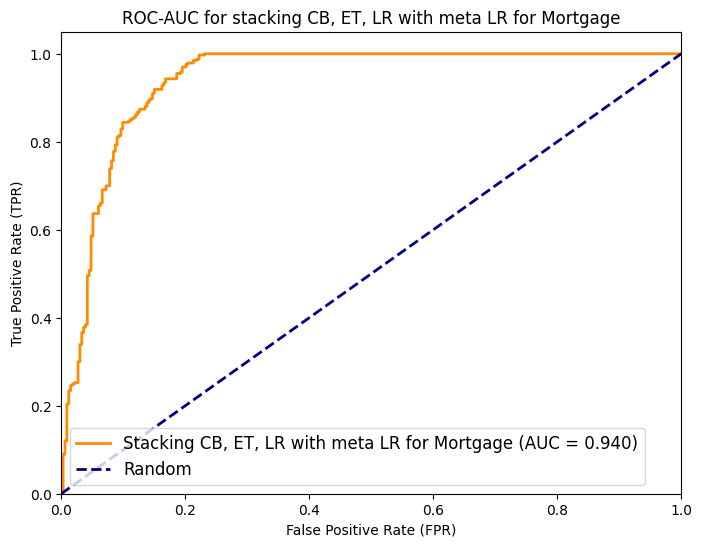

In [59]:
rf_models = [sk_stacking_mortgage_clf_cb_et_lr]
rf_names = ["Stacking CB, ET, LR with meta LR for Mortgage"]
colors = ["darkorange"]
X_test = [X_val_Mortgage]
y_test = [y_val_Mortgage]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking CB, ET, LR with meta LR for Mortgage")

##### Meta MLP

In [60]:
estimators_mortgage_cb_et_lr_metamlp = [('cb', cb_mortgage),
                                        ('et', et_mortgage),
                                        ('lr', lr_mortgage)]

sk_stacking_mortgage_clf_cb_et_lr_metamlp, roc_auc_mortgage_cb_et_lr_metamlp = run_stacking(
    estimators_mortgage_cb_et_lr_metamlp, MLPClassifier(max_iter=300), X_train_Mortgage, y_train_Mortgage, X_val_Mortgage, y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0:	learn: 0.5451172	total: 15.7ms	remaining: 13.2s
1:	learn: 0.4709403	total: 30.1ms	remaining: 12.6s
2:	learn: 0.3962930	total: 44.3ms	remaining: 12.3s
3:	learn: 0.3601782	total: 59.6ms	remaining: 12.4s
4:	learn: 0.3261697	total: 73.8ms	remaining: 12.3s
5:	learn: 0.3023079	total: 88.1ms	remaining: 12.2s
6:	learn: 0.2850861	total: 102ms	remaining: 12.2s
7:	learn: 0.2722250	total: 117ms	remaining: 12.1s
8:	learn: 0.2518365	total: 132ms	remaining: 12.2s
9:	learn: 0.2445693	total: 146ms	remaining: 12.1s
10:	learn: 0.2388929	total: 161ms	remaining: 12.1s
11:	learn: 0.2346208	total: 198ms	remaining: 13.7s
12:	learn: 0.2310518	total: 219ms	remaining: 13.9s
13:	learn: 0.2204609	total: 248ms	remaining: 14.6s
14:	learn: 0.2133395	total: 267ms	remaining: 14.7s
15:	learn: 0.2120868	total: 298ms	remaining: 15.3s
16:	learn: 0.2082902	total: 328ms	remaining: 15.9s
17:	learn: 0.2060058	total: 348ms	remaining: 15.9s
18:	learn: 0.2051559	total: 375ms	remaining: 16.2s
19:	learn: 0.2046219	total: 406ms	r

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.5779880	total: 27.1ms	remaining: 22.7s
1:	learn: 0.4606012	total: 54.2ms	remaining: 22.7s
2:	learn: 0.4083207	total: 78.8ms	remaining: 22s
3:	learn: 0.3649889	total: 106ms	remaining: 22.1s
4:	learn: 0.3179042	total: 132ms	remaining: 22s
5:	learn: 0.2950745	total: 159ms	remaining: 22.1s
6:	learn: 0.2784661	total: 190ms	remaining: 22.6s
7:	learn: 0.2668542	total: 216ms	remaining: 22.5s
8:	learn: 0.2577552	total: 242ms	remaining: 22.3s
9:	learn: 0.2503023	total: 268ms	remaining: 22.2s
10:	learn: 0.2444112	total: 296ms	remaining: 22.3s
11:	learn: 0.2329101	total: 318ms	remaining: 21.9s
12:	learn: 0.2296876	total: 342ms	remaining: 21.7s
13:	learn: 0.2232932	total: 368ms	remaining: 21.7s
14:	learn: 0.2212725	total: 386ms	remaining: 21.2s
15:	learn: 0.2196272	total: 415ms	remaining: 21.3s
16:	learn: 0.2190605	total: 434ms	remaining: 21s
17:	learn: 0.2167883	total: 464ms	remaining: 21.1s
18:	learn: 0.2162394	total: 483ms	remaining: 20.8s
19:	learn: 0.2126068	total: 507ms	remaining:

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

AUC for Stacking CB, ET, LR with meta MLP for Mortgage: 0.9412520628736845


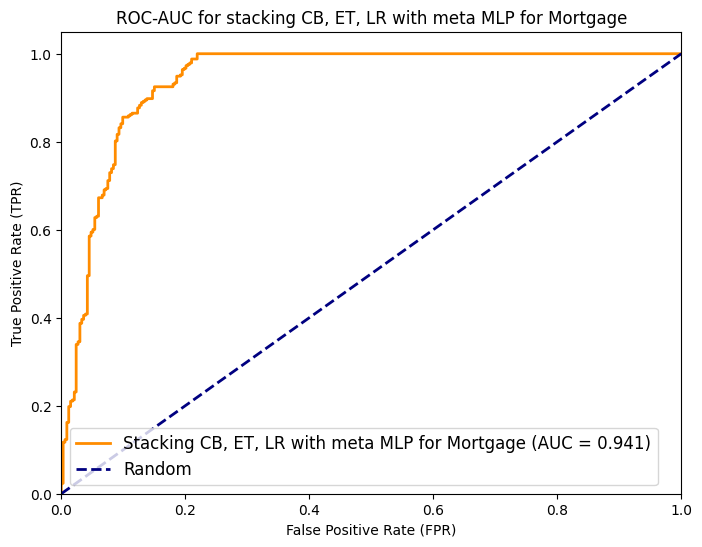

In [61]:
rf_models = [sk_stacking_mortgage_clf_cb_et_lr_metamlp]
rf_names = ["Stacking CB, ET, LR with meta MLP for Mortgage"]
colors = ["darkorange"]
X_test = [X_val_Mortgage]
y_test = [y_val_Mortgage]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking CB, ET, LR with meta MLP for Mortgage")

#### ExtraTrees, CatBoost

##### Meta LR

In [62]:
estimators_mortgage_et_cb = [('et', et_mortgage),
                             ('cb', cb_mortgage)]


sk_stacking_mortgage_clf_et_cb, roc_auc_mortgage_et_cb = run_stacking(
    estimators_mortgage_et_cb, LogisticRegression(), X_train_Mortgage, y_train_Mortgage, X_val_Mortgage, y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Выходные данные были обрезаны до нескольких последних строк (5000).
34:	learn: 0.1958630	total: 549ms	remaining: 12.6s
35:	learn: 0.1954600	total: 566ms	remaining: 12.6s
36:	learn: 0.1952952	total: 583ms	remaining: 12.6s
37:	learn: 0.1951792	total: 598ms	remaining: 12.6s
38:	learn: 0.1947171	total: 613ms	remaining: 12.6s
39:	learn: 0.1944638	total: 628ms	remaining: 12.5s
40:	learn: 0.1944236	total: 643ms	remaining: 12.5s
41:	learn: 0.1943401	total: 658ms	remaining: 12.5s
42:	learn: 0.1938496	total: 673ms	remaining: 12.5s
43:	learn: 0.1935291	total: 687ms	remaining: 12.4s
44:	learn: 0.1923659	total: 704ms	remaining: 12.4s
45:	learn: 0.1923274	total: 716ms	remaining: 12.3s
46:	learn: 0.1922986	total: 729ms	remaining: 12.3s
47:	learn: 0.1922580	total: 744ms	remaining: 12.3s
48:	learn: 0.1921221	total: 758ms	remaining: 12.2s
49:	learn: 0.1917359	total: 773ms	remaining: 12.2s
50:	learn: 0.1913440	total: 789ms	remaining: 12.2s
51:	learn: 0.1912371	total: 803ms	remaining: 12.2s
52:	learn: 0.1

AUC for Stacking ET, CB with meta LR for Mortgage: 0.9404314224134045


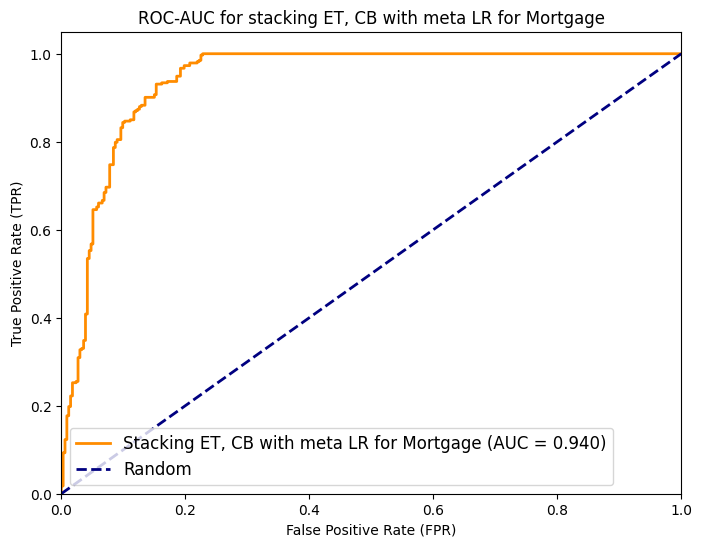

In [63]:
rf_models = [sk_stacking_mortgage_clf_et_cb]
rf_names = ["Stacking ET, CB with meta LR for Mortgage"]
colors = ["darkorange"]
X_test = [X_val_Mortgage]
y_test = [y_val_Mortgage]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, CB with meta LR for Mortgage")

##### Meta MLP

In [64]:
estimators_mortgage_et_cb_metamlp = [('et', et_mortgage),
                                     ('cb', cb_mortgage)]


sk_stacking_mortgage_clf_et_cb_metamlp, roc_auc_mortgage_et_cb_metamlp = run_stacking(
    estimators_mortgage_et_cb_metamlp, MLPClassifier(max_iter=300), X_train_Mortgage, y_train_Mortgage, X_val_Mortgage, y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Выходные данные были обрезаны до нескольких последних строк (5000).
34:	learn: 0.1958630	total: 534ms	remaining: 12.3s
35:	learn: 0.1954600	total: 548ms	remaining: 12.2s
36:	learn: 0.1952952	total: 563ms	remaining: 12.2s
37:	learn: 0.1951792	total: 580ms	remaining: 12.2s
38:	learn: 0.1947171	total: 596ms	remaining: 12.2s
39:	learn: 0.1944638	total: 611ms	remaining: 12.2s
40:	learn: 0.1944236	total: 626ms	remaining: 12.2s
41:	learn: 0.1943401	total: 641ms	remaining: 12.2s
42:	learn: 0.1938496	total: 656ms	remaining: 12.1s
43:	learn: 0.1935291	total: 670ms	remaining: 12.1s
44:	learn: 0.1923659	total: 685ms	remaining: 12.1s
45:	learn: 0.1923274	total: 697ms	remaining: 12s
46:	learn: 0.1922986	total: 710ms	remaining: 12s
47:	learn: 0.1922580	total: 722ms	remaining: 11.9s
48:	learn: 0.1921221	total: 736ms	remaining: 11.9s
49:	learn: 0.1917359	total: 751ms	remaining: 11.9s
50:	learn: 0.1913440	total: 766ms	remaining: 11.8s
51:	learn: 0.1912371	total: 780ms	remaining: 11.8s
52:	learn: 0.19085

AUC for Stacking ET, CB with meta MLP for Mortgage: 0.9408733057381705


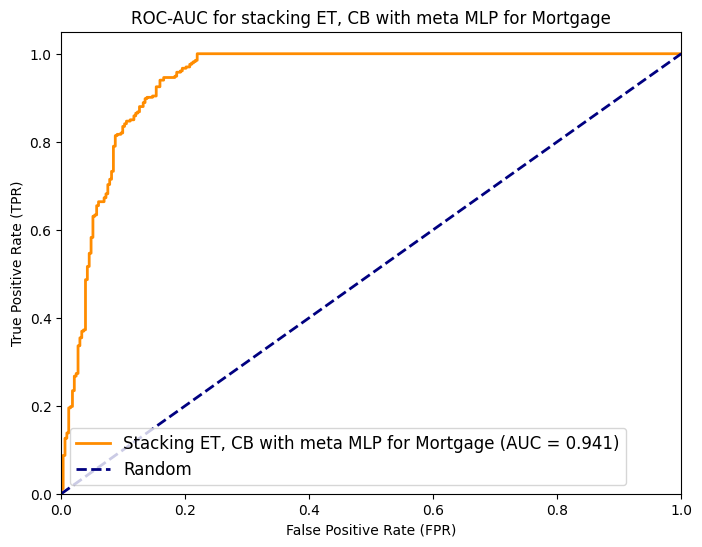

In [65]:
rf_models = [sk_stacking_mortgage_clf_et_cb_metamlp]
rf_names = ["Stacking ET, CB with meta MLP for Mortgage"]
colors = ["darkorange"]
X_test = [X_val_Mortgage]
y_test = [y_val_Mortgage]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, CB with meta MLP for Mortgage")

### Pension

#### XGBoost, ExtraTrees, LogisticRegression

##### Meta LR

In [67]:
estimators_pension_xgb_et_lr = [('xgb', xgb_pension),
                                ('et', et_pension),
                                ('lr', lr_pension)]


sk_stacking_pension_clf_xgb_et_lr, roc_auc_pension_xgb_et_lr = run_stacking(
    estimators_pension_xgb_et_lr, LogisticRegression(), X_train_Pension, y_train_Pension, X_val_Pension, y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

AUC for Stacking XGB, ET, LR with meta LR for Pension: 0.7790161812834691


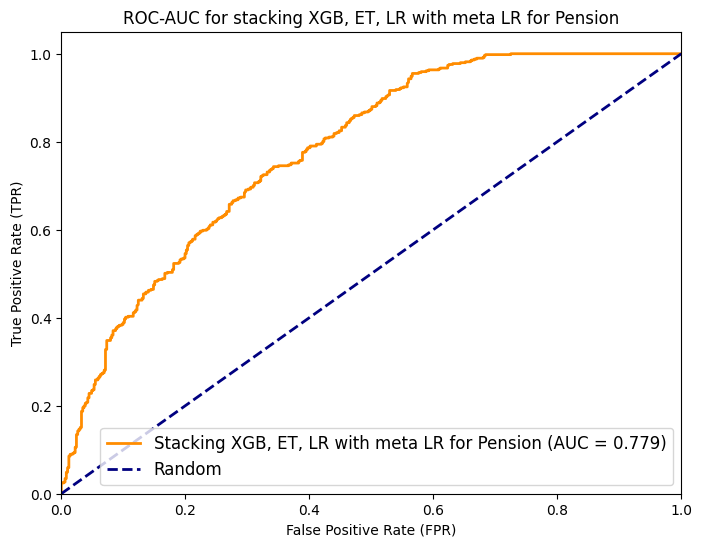

In [68]:
rf_models = [sk_stacking_pension_clf_xgb_et_lr]
rf_names = ["Stacking XGB, ET, LR with meta LR for Pension"]
colors = ["darkorange"]
X_test = [X_val_Pension]
y_test = [y_val_Pension]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking XGB, ET, LR with meta LR for Pension")

##### Meta MLP

In [71]:
estimators_pension_xgb_et_lr_metamlp = [('xgb', xgb_pension),
                                        ('et', et_pension),
                                        ('lr', lr_pension)]


sk_stacking_pension_clf_xgb_et_lr_metamlp, roc_auc_pension_xgb_et_lr_metamlp = run_stacking(
    estimators_pension_xgb_et_lr_metamlp, MLPClassifier(max_iter=300), X_train_Pension, y_train_Pension, X_val_Pension, y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

AUC for Stacking XGB, ET, LR with meta MLP for Pension: 0.7777800822130321


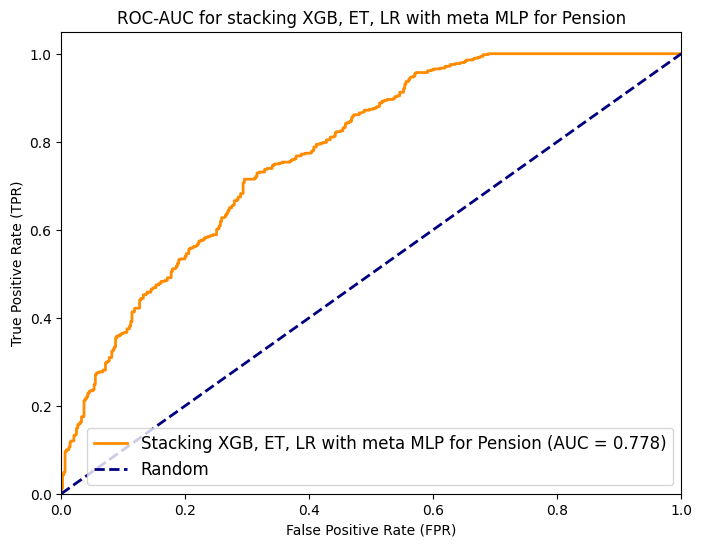

In [72]:
rf_models = [sk_stacking_pension_clf_xgb_et_lr_metamlp]
rf_names = ["Stacking XGB, ET, LR with meta MLP for Pension"]
colors = ["darkorange"]
X_test = [X_val_Pension]
y_test = [y_val_Pension]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking XGB, ET, LR with meta MLP for Pension")

#### ExtraTrees, XGBoost

##### Meta LR

In [84]:
estimators_pension_et_xgb = [('et', et_pension),
                             ('xgb', xgb_pension)]


sk_stacking_pension_clf_et_xgb, roc_auc_pension_et_xgb = run_stacking(
    estimators_pension_et_xgb, LogisticRegression(), X_train_Pension, y_train_Pension, X_val_Pension, y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


AUC for Stacking ET, XGB with meta LR for Pension: 0.7793687598773856


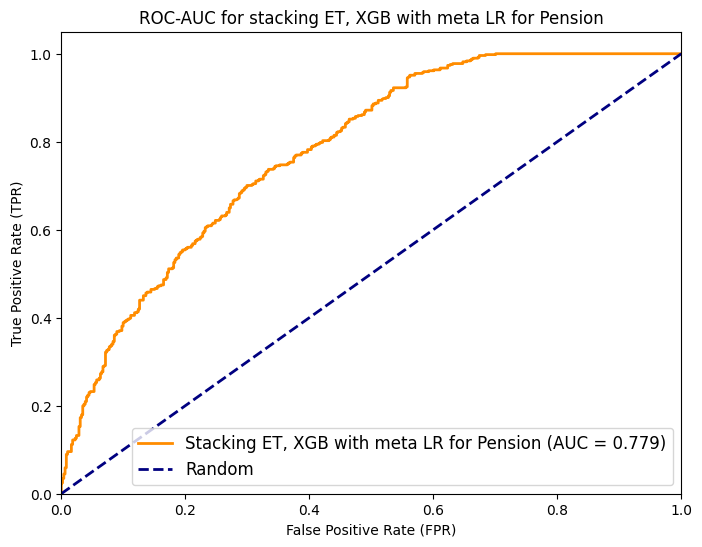

In [85]:
rf_models = [sk_stacking_pension_clf_et_xgb]
rf_names = ["Stacking ET, XGB with meta LR for Pension"]
colors = ["darkorange"]
X_test = [X_val_Pension]
y_test = [y_val_Pension]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, XGB with meta LR for Pension")

##### Meta MLP

In [78]:
estimators_pension_et_xgb_metamlp = [('et', et_pension),
                             ('xgb', xgb_pension)]


sk_stacking_pension_clf_et_xgb_metamlp, roc_auc_pension_et_xgb_metamlp = run_stacking(
    estimators_pension_et_xgb_metamlp, MLPClassifier(max_iter=300), X_train_Pension, y_train_Pension, X_val_Pension, y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


AUC for Stacking ET, XGB with meta MLP for Pension: 0.7792360244067347


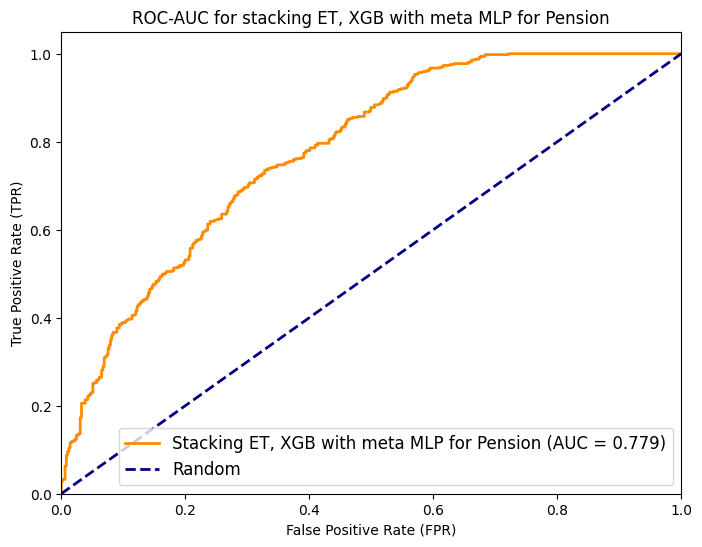

In [79]:
rf_models = [sk_stacking_pension_clf_et_xgb_metamlp]
rf_names = ["Stacking ET, XGB with meta MLP for Pension"]
colors = ["darkorange"]
X_test = [X_val_Pension]
y_test = [y_val_Pension]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, XGB with meta MLP for Pension")

### Savings

#### XGBoost, ExtraTrees, LogisticRegression

##### Meta LR

In [87]:
estimators_savings_xgb_et_lr = [('xgb', xgb_savings),
                                ('et', et_savings),
                                ('lr', lr_savings)]


sk_stacking_savings_clf_xgb_et_lr, roc_auc_savings_xgb_et_lr = run_stacking(
    estimators_savings_xgb_et_lr, LogisticRegression(), X_train_Savings, y_train_Savings, X_val_Savings, y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

AUC for Stacking XGB, ET, LR with meta LR for Savings: 0.6957424459927875


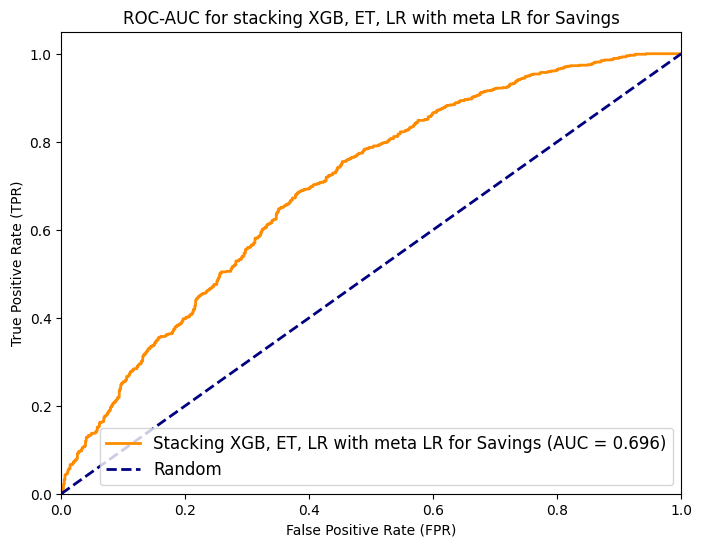

In [88]:
rf_models = [sk_stacking_savings_clf_xgb_et_lr]
rf_names = ["Stacking XGB, ET, LR with meta LR for Savings"]
colors = ["darkorange"]
X_test = [X_val_Savings]
y_test = [y_val_Savings]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking XGB, ET, LR with meta LR for Savings")

##### Meta MLP

In [89]:
estimators_savings_xgb_et_lr_metamlp = [('xgb', xgb_savings),
                                        ('et', et_savings),
                                        ('lr', lr_savings)]


sk_stacking_savings_clf_xgb_et_lr_metamlp, roc_auc_savings_xgb_et_lr_metamlp = run_stacking(
    estimators_savings_xgb_et_lr_metamlp, MLPClassifier(max_iter=300), X_train_Savings, y_train_Savings, X_val_Savings, y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

AUC for Stacking XGB, ET, LR with meta MLP for Savings: 0.6962662371765694


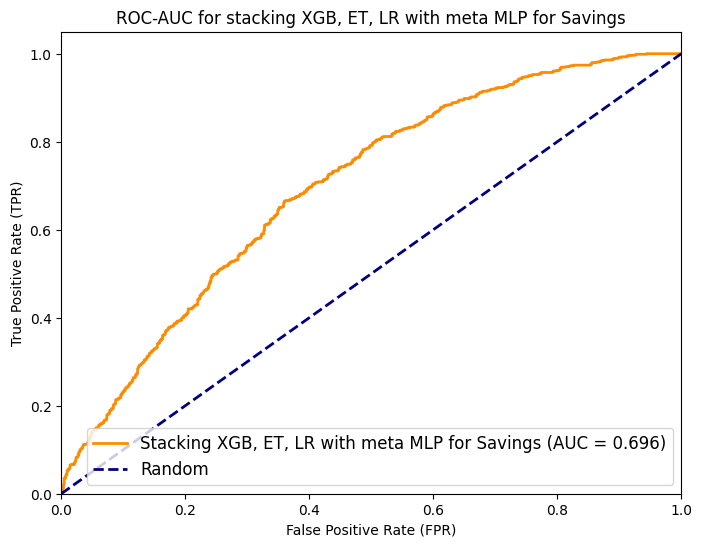

In [90]:
rf_models = [sk_stacking_savings_clf_xgb_et_lr_metamlp]
rf_names = ["Stacking XGB, ET, LR with meta MLP for Savings"]
colors = ["darkorange"]
X_test = [X_val_Savings]
y_test = [y_val_Savings]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking XGB, ET, LR with meta MLP for Savings")

#### ExtraTrees, XGBoost

##### Meta LR

In [91]:
estimators_savings_et_xgb = [('et', et_savings),
                             ('xgb', xgb_savings)]


sk_stacking_savings_clf_et_xgb, roc_auc_savings_et_xgb = run_stacking(
    estimators_savings_et_xgb, LogisticRegression(), X_train_Savings, y_train_Savings, X_val_Savings, y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


AUC for Stacking ET, XGB with meta LR for Savings: 0.6934344035572985


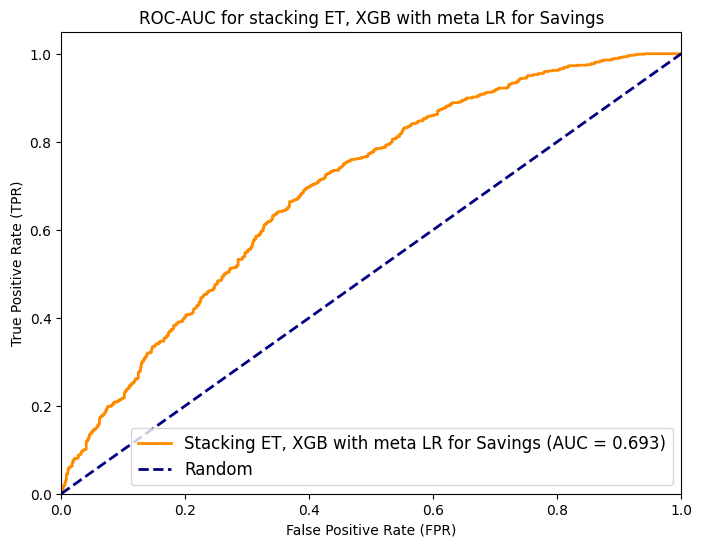

In [92]:
rf_models = [sk_stacking_savings_clf_et_xgb]
rf_names = ["Stacking ET, XGB with meta LR for Savings"]
colors = ["darkorange"]
X_test = [X_val_Savings]
y_test = [y_val_Savings]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, XGB with meta LR for Savings")

##### Meta MLP

In [93]:
estimators_savings_et_xgb_metamlp = [('et', et_savings),
                                     ('xgb', xgb_savings)]


sk_stacking_savings_clf_et_xgb_metamlp, roc_auc_savings_et_xgb_metamlp = run_stacking(
    estimators_savings_et_xgb_metamlp, MLPClassifier(max_iter=300), X_train_Savings, y_train_Savings, X_val_Savings, y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


AUC for Stacking ET, XGB with meta MLP for Savings: 0.6926977346731557


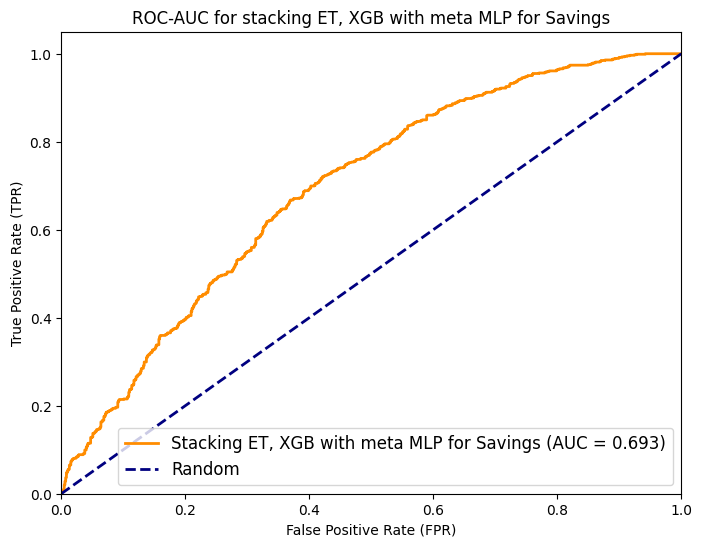

In [94]:
rf_models = [sk_stacking_savings_clf_et_xgb_metamlp]
rf_names = ["Stacking ET, XGB with meta MLP for Savings"]
colors = ["darkorange"]
X_test = [X_val_Savings]
y_test = [y_val_Savings]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking ET, XGB with meta MLP for Savings")

## Выбор и сохранение лучших моделей

### Mortgage

AUC for Stacking CB, XGB, LGB with meta LR: 0.9418472526580635
AUC for Stacking ET, LR, MLP with meta MLP: 0.9404224043863683
AUC for Stacking CB, ET, LR with meta MLP: 0.9412520628736845
AUC for Stacking ET, CB with meta MLP: 0.9408733057381705


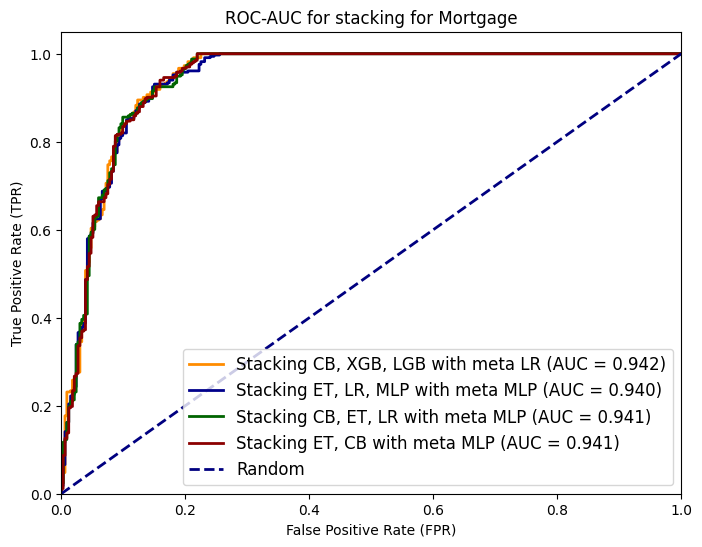

In [66]:
rf_models = [sk_stacking_mortgage_clf_cb_xgb_lgb, sk_stacking_mortgage_clf_et_lr_mlp_metamlp,
             sk_stacking_mortgage_clf_cb_et_lr_metamlp, sk_stacking_mortgage_clf_et_cb_metamlp]
rf_names = ["Stacking CB, XGB, LGB with meta LR", "Stacking ET, LR, MLP with meta MLP",
            "Stacking CB, ET, LR with meta MLP", "Stacking ET, CB with meta MLP"]
colors = ["darkorange", "darkblue", "darkgreen", "darkred"]
X_test = [X_val_Mortgage, X_val_Mortgage, X_val_Mortgage, X_val_Mortgage]
y_test = [y_val_Mortgage, y_val_Mortgage, y_val_Mortgage, y_val_Mortgage]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking for Mortgage")

Выведем параметры лучшей модели.

In [98]:
sk_stacking_mortgage_clf_cb_xgb_lgb.get_params()

{'cv': None,
 'estimators': [('cb', <catboost.core.CatBoostClassifier at 0x7b630b30ba50>),
  ('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.9712108470499956, device=None,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, gamma=4.927111346239827,
                 grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.13020051661181956,
                 max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=14, max_leaves=None,
                 min_child_weight=10, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=234, n_jobs=None,
                 num_parallel_tree=None, random_state=None, ...)),
  ('lgb',
   LGBMClassifier(colsample_bytree=0.93673

Сохраним модель.

In [99]:
joblib.dump(sk_stacking_mortgage_clf_cb_xgb_lgb, "/content/best_mortgage_stacking")

['/content/best_mortgage_stacking']

### Pension

AUC for Stacking CB, XGB, LGB with meta LR: 0.7784852394008653
AUC for Stacking ET, LR, MLP with meta LR: 0.7791572127210357
AUC for Stacking XGB, ET, LR with meta LR: 0.7790161812834691
AUC for Stacking ET, XGB with meta LR: 0.7793687598773856


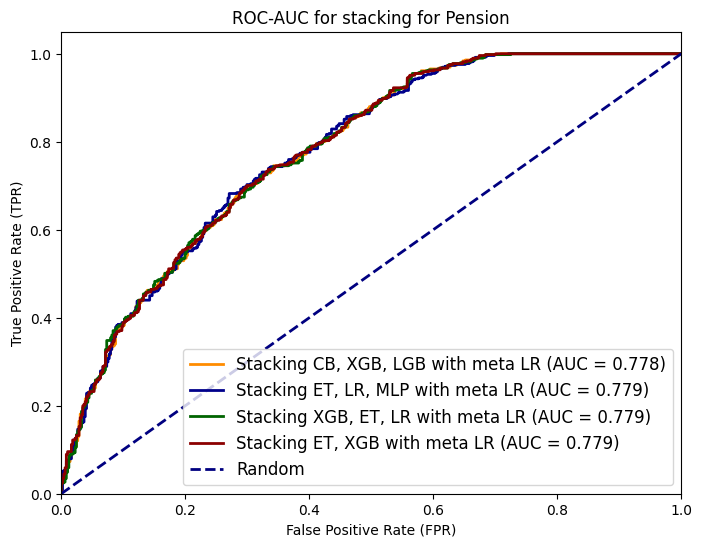

In [86]:
rf_models = [sk_stacking_pension_clf_cb_xgb_lgb, sk_stacking_pension_clf_et_lr_mlp,
             sk_stacking_pension_clf_xgb_et_lr, sk_stacking_pension_clf_et_xgb]
rf_names = ["Stacking CB, XGB, LGB with meta LR", "Stacking ET, LR, MLP with meta LR",
            "Stacking XGB, ET, LR with meta LR", "Stacking ET, XGB with meta LR"]
colors = ["darkorange", "darkblue", "darkgreen", "darkred"]
X_test = [X_val_Pension, X_val_Pension, X_val_Pension, X_val_Pension]
y_test = [y_val_Pension, y_val_Pension, y_val_Pension, y_val_Pension]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking for Pension")

Параметры лучшей модели.

In [100]:
sk_stacking_pension_clf_et_xgb.get_params()

{'cv': None,
 'estimators': [('et',
   ExtraTreesClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=10)),
  ('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.5238187849054002, device=None,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, gamma=4.7308173402905505,
                 grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.058427369161116946,
                 max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=3, max_leaves=None,
                 min_child_weight=6, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=238, n_jobs=None,
                 num_parallel_tree=None, random_state=None, ...))],
 'final_estimator__C': 1

Сохраняем в файл.

In [101]:
joblib.dump(sk_stacking_pension_clf_et_xgb, "/content/best_pension_stacking")

['/content/best_pension_stacking']

### Savings

AUC for Stacking CB, XGB, LGB with meta MLP: 0.6914876930079479
AUC for Stacking ET, LR, MLP with meta MLP: 0.6957172367914288
AUC for Stacking XGB, ET, LR with meta MLP: 0.6962662371765694
AUC for Stacking ET, XGB with meta LR: 0.6934344035572985


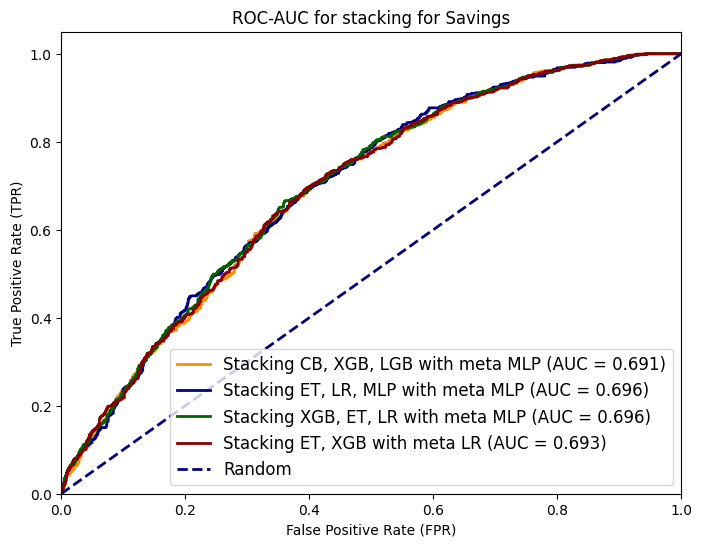

In [95]:
rf_models = [sk_stacking_savings_clf_cb_xgb_lgb_metamlp, sk_stacking_savings_clf_et_lr_mlp_metamlp,
             sk_stacking_savings_clf_xgb_et_lr_metamlp, sk_stacking_savings_clf_et_xgb]
rf_names = ["Stacking CB, XGB, LGB with meta MLP", "Stacking ET, LR, MLP with meta MLP",
            "Stacking XGB, ET, LR with meta MLP", "Stacking ET, XGB with meta LR"]
colors = ["darkorange", "darkblue", "darkgreen", "darkred"]
X_test = [X_val_Savings, X_val_Savings, X_val_Savings, X_val_Savings]
y_test = [y_val_Savings, y_val_Savings, y_val_Savings, y_val_Savings]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for stacking for Savings")

Параметры лучшей модели.

In [102]:
sk_stacking_savings_clf_xgb_et_lr_metamlp.get_params()

{'cv': None,
 'estimators': [('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.6399123535237496, device=None,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, gamma=4.7135127571247475,
                 grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.17633766607373635,
                 max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=3, max_leaves=None,
                 min_child_weight=10, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=1446, n_jobs=None,
                 num_parallel_tree=None, random_state=None, ...)),
  ('et',
   ExtraTreesClassifier(max_depth=10, min_samples_split=10, n_estimators=200)),
  ('lr', LogisticRegressio

Сохраняем модель.

In [103]:
joblib.dump(sk_stacking_savings_clf_xgb_et_lr_metamlp, "/content/best_savings_stacking")

['/content/best_savings_stacking']

## Итоги

AUC for Stacking CB, XGB, LGB with meta LR for Mortgage: 0.9418472526580635
AUC for Stacking ET, XGB with meta LR for Pension: 0.7793687598773856
AUC for Stacking XGB, ET, LR with meta MLP for Savings: 0.6962662371765694


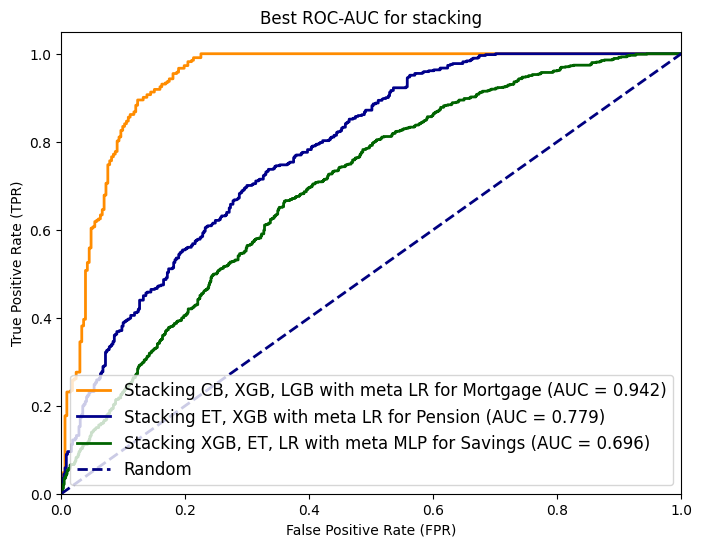

In [106]:
rf_models = [sk_stacking_mortgage_clf_cb_xgb_lgb, sk_stacking_pension_clf_et_xgb, sk_stacking_savings_clf_xgb_et_lr_metamlp]
rf_names = ["Stacking CB, XGB, LGB with meta LR for Mortgage", "Stacking ET, XGB with meta LR for Pension", "Stacking XGB, ET, LR with meta MLP for Savings"]
colors = ["darkorange", "darkblue", "darkgreen"]
X_test = [X_val_Mortgage, X_val_Pension, X_val_Savings]
y_test = [y_val_Mortgage, y_val_Pension, y_val_Savings]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="Best ROC-AUC for stacking")